In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
df = pd.read_parquet("./data/cleaned.feather")

### Standard OLS

Let's just feed the data to various OLS models. This is a powerful data exploration mechanism since it lets you see the relationship between variables.

If you're not familiar with OLS, it's effectively the same idea as drawing the line of "best fit" through the scatter plots. What OLS also does is show the interactions betwen varialbes while keeping the rest constant. In other words, if a variable has a strong relationship (correlation) with temperature, it will "use up" most of the influence, leaving little for less influential variables. This way, you can spot things that don't seem to affect temperature.

Note: it would seem that `usage` doesn't affect temperature a lot. Yet `usage` is a value that goes from 0 to 100, while all other variables are in the 0 to 1 range. The coefficient for `usage` is actually stronger than it seems.

You may be familiar with OLS from machine learning, but the dashboard below will be new to you. The dashboard provides lots of diagnostic values for the model.

#### Results

As expected, intake and exhaust fans are great for reducing temperatures, with intake fans being more effective. They must do this by pushing air straight onto the CPU.

Interestingly, the case component with the power and HDMI cable helps dissipate a bit more heat than its counterparts. All of these tests were done with a power and an HDMI cable. From other tests I've done, the HDMI does seem to add heat to the computer, so having the case there may spread some of that HDMI heat away from the CPU. **Interesting!**

Have a look at the `std err` (standard error) and `t` (Student t-statistic). The `case_under` and `case_cable` have relatively high errors. This must be an effect of the case dependance: since the bottom and frame are almost always present, the model doesn't have enough data to distinguish them from the reference case (a bare Raspberry Pi board).

#### Methods

Below we run three different models. Each uses different levels of interaction for the dummies. For example, `usage:top_solid` means multiply the `top_solid` dummy with `usage`. `usage*top_solid` means we get `usage:top_solid` but also keep the regular `top_solid` too.

In [3]:
dummy_model = smf.ols("temp ~ usage + case_under + case_frame + case_cable + case_gpio + top_solid + top_holed + top_intake + top_exhaust", data=df).fit()

print(dummy_model.summary())

                            OLS Regression Results                            
Dep. Variable:                   temp   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                 4.951e+04
Date:                Mon, 07 Sep 2020   Prob (F-statistic):               0.00
Time:                        13:53:37   Log-Likelihood:            -1.6432e+05
No. Observations:               61058   AIC:                         3.287e+05
Df Residuals:                   61048   BIC:                         3.288e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      65.8071      0.063   1049.222      

#### Plots

Let's have a look at the dummy model since it's the simplest.

The linear model is a function that accepts values and outputs a predicted temperature value. This predicted temperature value is a predicted mean value, not a single point value. You can see this by looking at the standard errors and confidence intervals above.

In [4]:
# Predict temperature of a made-up situation
# The side panels are present without a case frame
# Also, both top_intake and top_exhaust fans are present
dummy_model.predict({
    "usage"       : [42],
    "case_under"  : [0],
    "case_frame"  : [0],
    "case_cable"  : [1],
    "case_gpio"   : [1],
    "top_solid"   : [0],
    "top_holed"   : [0],
    "top_intake"  : [1],
    "top_exhaust" : [1]
})

0    36.656111
dtype: float64

With this technique, we can compare different case components in (hopefully) a more fair way.

Let's use the model to simulate temperatures at 100% where only one case component is present.

Why simulate with only one case item present? We are trying to get rid of the dependence effect. Unfortunately, we can only do this to the extent that the model coefficients are significantly different from zero. We can't be completely sure how `case_under` and `case_frame` behave.

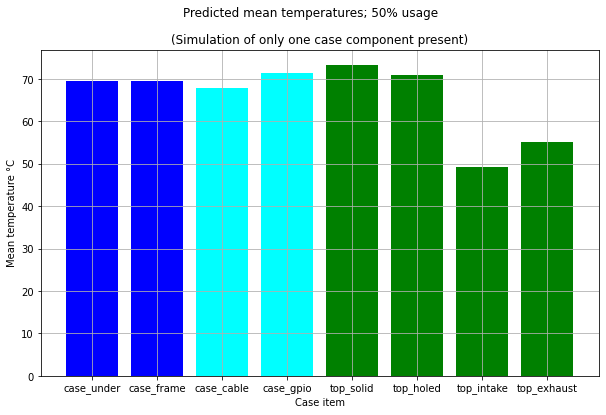

In [5]:
base_scenario = pd.DataFrame({
    "usage"       : [50],
    "case_under"  : [0],
    "case_frame"  : [0],
    "case_cable"  : [0],
    "case_gpio"   : [0],
    "top_solid"   : [0],
    "top_holed"   : [0],
    "top_intake"  : [0],
    "top_exhaust" : [0]
})

# Make a list of labels/dummies
dummies = ["case_under", "case_frame", "case_cable", "case_gpio", "top_solid", "top_holed", "top_intake", "top_exhaust"]

# Give them colors to use later
colors = 2*["blue"] + 2*["cyan"] + 4*["green"]

# Create a function to make predictions conveniently
def set_true_and_predict(dummy):
    scenario = base_scenario.assign()
    scenario[dummy] = 1
    return(float(dummy_model.predict(scenario)))

# Create a dictionary of labels and predictions
values = {k:v for k, v in zip(dummies, [set_true_and_predict(x) for x in dummies])}

plt.figure(figsize=(10,6))
plt.suptitle("Predicted mean temperatures; 50% usage")
plt.title("(Simulation of only one case component present)")
plt.xlabel("Case item")
plt.ylabel("Mean temperature °C")
plt.bar(x=values.keys(),
        height=values.values(),
        color=colors)
plt.grid(True)
plt.savefig("./images/exp1_predicted_means.png")
plt.show()